<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
from pycocotools import mask
TRAIN_DIR = '/content/drive/MyDrive/trainingset'
TEST_DIR = '/content/drive/MyDrive/testset'
TRAIN_LABELS = '/content/drive/MyDrive/train.json'
TEST_LABELS =  '/content/drive/MyDrive/test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [4]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [5]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = torchvision.io.read_image(img_path)
    return image,label
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [6]:
#caricamento dei dataset di train e di test
train = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

In [ ]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train)
batch_size = 64

num_epochs = 3

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train) for i in range(num_epochs + 1)]

def train(epoch,model,criterion,optimizer,reshape=True):
    for batch_idx, (images, labels) in enumerate(train):
        # Move tensors to the configured device
        if reshape:
            images = images.reshape(-1, 28*28)
        #images = images.to(device)
        #labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train)))

In [14]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3):
    super(AutoEncoder,self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding = 1)
    self.pl = nn.MaxPool2d(2,stride = 2,return_indices=True)
    self.us = nn.MaxUnpool2d(2,stride=2)
    self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding = 1)
    self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding = 1)
    self.conv6 = nn.Conv2d(64, 3, kernel_size=3, padding = 1)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x, ind = self.pl(x)
    x = F.relu(self.us(x, ind))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    return x



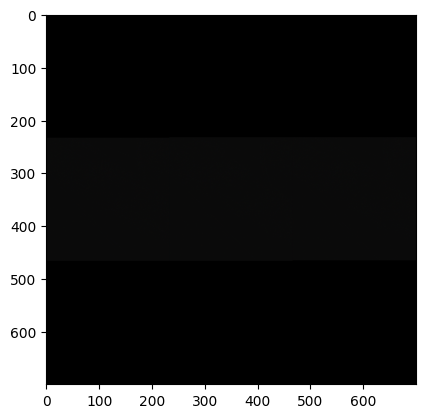

In [17]:
model = AutoEncoder()
imgs = torchvision.io.read_image('/content/drive/MyDrive/testset/04_2220.jpg')/255
res = model(imgs)
a = res.detach().numpy()
b = np.reshape(a,(700,700,3))
plt.imshow(b)